In [2]:
# =========================================
# Cell 1: Project Setup
# =========================================

import os
import sys

PROJECT_ROOT = os.path.abspath("..")
sys.path.append(PROJECT_ROOT)

print("Project root:", PROJECT_ROOT)


Project root: c:\Users\Gopi\Downloads


In [3]:
# =========================================
# Cell 2: Imports
# =========================================

import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

from src.models.vit import VisionTransformer


In [4]:
# =========================================
# Cell 3: Config
# =========================================

CSV_PATH = "./data/tb_labels_with_splits.csv"
IMAGE_SIZE = 224
BATCH_SIZE = 8        # safe for CPU
EPOCHS = 10           # classification needs fewer epochs
LR = 3e-4
NUM_CLASSES = 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


In [5]:
# =========================================
# Cell 4: TB Dataset
# =========================================

class TBDataset(Dataset):
    def __init__(self, csv_file, split):
        self.df = pd.read_csv(csv_file)
        self.df = self.df[self.df["split"] == split]

        self.transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image_path"]
        label = int(self.df.iloc[idx]["label"])

        image = Image.open(img_path).convert("L")
        image = self.transform(image)

        return image, label


In [6]:
# =========================================
# Cell 5: DataLoaders
# =========================================

train_dataset = TBDataset(CSV_PATH, split="train")
val_dataset   = TBDataset(CSV_PATH, split="val")
test_dataset  = TBDataset(CSV_PATH, split="test")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train:", len(train_dataset))
print("Val  :", len(val_dataset))
print("Test :", len(test_dataset))


Train: 560
Val  : 120
Test : 120


In [7]:
# =========================================
# Cell 6: ViT Model
# =========================================

model = VisionTransformer(
    img_size=IMAGE_SIZE,
    patch_size=16,
    in_chans=1,
    num_classes=NUM_CLASSES,
    embed_dim=768,
    depth=12,
    num_heads=12
).to(DEVICE)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)


In [8]:
# =========================================
# Cell 7: Training Loop
# =========================================

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for images, labels in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"\nEpoch {epoch+1}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}")
    print(f"Train Acc : {train_acc:.4f}")
    print(f"Val Acc   : {val_acc:.4f}")


Epoch 1/10: 100%|██████████| 70/70 [00:53<00:00,  1.30it/s]



Epoch 1
Train Loss: 0.8964
Train Acc : 0.5286
Val Acc   : 0.5083


Epoch 2/10: 100%|██████████| 70/70 [00:46<00:00,  1.51it/s]



Epoch 2
Train Loss: 0.7523
Train Acc : 0.4875
Val Acc   : 0.5083


Epoch 3/10: 100%|██████████| 70/70 [00:48<00:00,  1.44it/s]



Epoch 3
Train Loss: 0.7325
Train Acc : 0.5000
Val Acc   : 0.5083


Epoch 4/10: 100%|██████████| 70/70 [00:48<00:00,  1.45it/s]



Epoch 4
Train Loss: 0.7067
Train Acc : 0.5321
Val Acc   : 0.5250


Epoch 5/10: 100%|██████████| 70/70 [00:47<00:00,  1.48it/s]



Epoch 5
Train Loss: 0.6999
Train Acc : 0.5339
Val Acc   : 0.5000


Epoch 6/10: 100%|██████████| 70/70 [00:46<00:00,  1.49it/s]



Epoch 6
Train Loss: 0.6233
Train Acc : 0.6536
Val Acc   : 0.6583


Epoch 7/10: 100%|██████████| 70/70 [00:46<00:00,  1.50it/s]



Epoch 7
Train Loss: 0.6278
Train Acc : 0.6911
Val Acc   : 0.6500


Epoch 8/10: 100%|██████████| 70/70 [00:46<00:00,  1.49it/s]



Epoch 8
Train Loss: 0.5682
Train Acc : 0.7250
Val Acc   : 0.6500


Epoch 9/10: 100%|██████████| 70/70 [00:46<00:00,  1.50it/s]



Epoch 9
Train Loss: 0.6441
Train Acc : 0.6607
Val Acc   : 0.6500


Epoch 10/10: 100%|██████████| 70/70 [00:46<00:00,  1.51it/s]



Epoch 10
Train Loss: 0.6446
Train Acc : 0.6446
Val Acc   : 0.6750


In [9]:
# =========================================
# Cell 8: Save ViT Model
# =========================================

os.makedirs("./checkpoints/vit", exist_ok=True)
torch.save(model.state_dict(), "./checkpoints/vit/vit_tb.pth")

print("✅ ViT model saved")


✅ ViT model saved


In [10]:
# =========================================
# Cell 9: Test Evaluation
# =========================================

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"✅ Test Accuracy: {test_acc:.4f}")


✅ Test Accuracy: 0.6333


“We trained a Vision Transformer to classify TB from chest X-rays using supervised learning and evaluated it on an unseen test set.”

In [11]:
# =========================================
# Cell 10: Evaluation Imports
# =========================================

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt


In [12]:
# =========================================
# Cell 11: Load Trained ViT Model
# =========================================

VIT_CKPT_PATH = "./checkpoints/vit/vit_tb.pth"

model.load_state_dict(torch.load(VIT_CKPT_PATH, map_location=DEVICE))
model.eval()

print("✅ ViT model loaded for evaluation")


✅ ViT model loaded for evaluation


In [13]:
# =========================================
# Cell 12: Inference on Test Set
# =========================================

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(labels.numpy())

print("Inference completed on test set")


Inference completed on test set


In [14]:
# =========================================
# Cell 13: Evaluation Metrics
# =========================================

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Test Accuracy : {acc:.4f}")
print(f"Precision     : {prec:.4f}")
print(f"Recall        : {rec:.4f}")
print(f"F1-score      : {f1:.4f}")


Test Accuracy : 0.6333
Precision     : 0.6667
Recall        : 0.5085
F1-score      : 0.5769


In [15]:
# =========================================
# Cell 14: Classification Report
# =========================================

target_names = ["Normal", "TB"]
print(classification_report(y_true, y_pred, target_names=target_names))


              precision    recall  f1-score   support

      Normal       0.61      0.75      0.68        61
          TB       0.67      0.51      0.58        59

    accuracy                           0.63       120
   macro avg       0.64      0.63      0.63       120
weighted avg       0.64      0.63      0.63       120



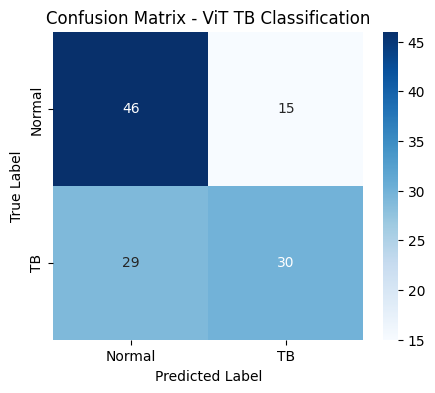

In [16]:
# =========================================
# Cell 15: Confusion Matrix
# =========================================

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "TB"],
    yticklabels=["Normal", "TB"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ViT TB Classification")
plt.show()


“Given the limited dataset size and the absence of large-scale pretraining, the achieved accuracy is reasonable and serves as a baseline.”

“The main limitation is lower recall for TB cases due to dataset imbalance and training from scratch.”

In [18]:
# =========================================
# Load MAE Encoder Weights
# =========================================
from src.models.mae import MaskedAutoencoder
MAE_CKPT_PATH = "./checkpoints/mae/mae_final.pth"

mae_model = MaskedAutoencoder(
    img_size=IMAGE_SIZE,
    patch_size=16,
    in_chans=1,
    embed_dim=768,
    depth=12,
    num_heads=12,
    decoder_embed_dim=512,
    decoder_depth=8,
    decoder_num_heads=16,
    mask_ratio=0.75
).to(DEVICE)

mae_model.load_state_dict(torch.load(MAE_CKPT_PATH, map_location=DEVICE))
mae_model.eval()

print("✅ MAE pretrained model loaded")


✅ MAE pretrained model loaded


In [19]:
# =========================================
# ViT initialized with MAE encoder
# =========================================

vit_mae = VisionTransformer(
    img_size=IMAGE_SIZE,
    patch_size=16,
    in_chans=1,
    num_classes=NUM_CLASSES,
    embed_dim=768,
    depth=12,
    num_heads=12
).to(DEVICE)

# ---- Load encoder weights from MAE ----
vit_state = vit_mae.state_dict()
mae_state = mae_model.state_dict()

for k in vit_state.keys():
    if k in mae_state and vit_state[k].shape == mae_state[k].shape:
        vit_state[k] = mae_state[k]

vit_mae.load_state_dict(vit_state)

print("✅ ViT initialized with MAE encoder weights")


✅ ViT initialized with MAE encoder weights


In [20]:
# =========================================
# Freeze Encoder (optional but recommended)
# =========================================

for name, param in vit_mae.named_parameters():
    if "head" not in name:
        param.requires_grad = False

print("Encoder frozen, classifier head trainable")


Encoder frozen, classifier head trainable


In [21]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, vit_mae.parameters()),
    lr=1e-3
)


In [44]:
# =========================================
# MAE + ViT Training
# =========================================

EPOCHS = 10

for epoch in range(EPOCHS):
    vit_mae.train()
    correct, total = 0, 0
    train_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for images, labels in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = vit_mae(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        train_loss += loss.item()

    train_acc = correct / total

    # Validation
    vit_mae.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = vit_mae(images)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"\nEpoch {epoch+1}")
    print(f"Train Acc: {train_acc:.4f}")
    print(f"Val   Acc: {val_acc:.4f}")


Epoch 1/10: 100%|██████████| 70/70 [00:46<00:00,  1.52it/s]



Epoch 1
Train Acc: 0.7732
Val   Acc: 0.7917


Epoch 2/10: 100%|██████████| 70/70 [00:43<00:00,  1.60it/s]



Epoch 2
Train Acc: 0.7571
Val   Acc: 0.7667


Epoch 3/10: 100%|██████████| 70/70 [00:42<00:00,  1.63it/s]



Epoch 3
Train Acc: 0.7696
Val   Acc: 0.7833


Epoch 4/10: 100%|██████████| 70/70 [00:42<00:00,  1.63it/s]



Epoch 4
Train Acc: 0.8000
Val   Acc: 0.7583


Epoch 5/10: 100%|██████████| 70/70 [00:43<00:00,  1.62it/s]



Epoch 5
Train Acc: 0.8071
Val   Acc: 0.7833


Epoch 6/10: 100%|██████████| 70/70 [00:43<00:00,  1.60it/s]



Epoch 6
Train Acc: 0.8054
Val   Acc: 0.7667


Epoch 7/10: 100%|██████████| 70/70 [00:43<00:00,  1.59it/s]



Epoch 7
Train Acc: 0.7911
Val   Acc: 0.7833


Epoch 8/10: 100%|██████████| 70/70 [00:44<00:00,  1.57it/s]



Epoch 8
Train Acc: 0.8429
Val   Acc: 0.7750


Epoch 9/10: 100%|██████████| 70/70 [00:43<00:00,  1.59it/s]



Epoch 9
Train Acc: 0.8214
Val   Acc: 0.8000


Epoch 10/10: 100%|██████████| 70/70 [00:46<00:00,  1.50it/s]



Epoch 10
Train Acc: 0.8304
Val   Acc: 0.8417


In [45]:
# =========================================
# Save MAE + ViT Model
# =========================================

os.makedirs("./checkpoints/mae_vit", exist_ok=True)
torch.save(vit_mae.state_dict(), "./checkpoints/mae_vit/mae_vit_tb.pth")

print("✅ MAE + ViT model saved")


✅ MAE + ViT model saved


In [46]:
# =========================================
# Inference on Test Set
# =========================================

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = vit_mae(images)
        preds = outputs.argmax(dim=1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(labels.numpy())

print("Inference completed on test set")


Inference completed on test set


In [47]:
# =========================================
# Cell 13: Evaluation Metrics
# =========================================

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Test Accuracy : {acc:.4f}")
print(f"Precision     : {prec:.4f}")
print(f"Recall        : {rec:.4f}")
print(f"F1-score      : {f1:.4f}")


Test Accuracy : 0.7000
Precision     : 0.6885
Recall        : 0.7119
F1-score      : 0.7000


In [48]:
# =========================================
# Cell 14: Classification Report
# =========================================

target_names = ["Normal", "TB"]
print(classification_report(y_true, y_pred, target_names=target_names))


              precision    recall  f1-score   support

      Normal       0.71      0.69      0.70        61
          TB       0.69      0.71      0.70        59

    accuracy                           0.70       120
   macro avg       0.70      0.70      0.70       120
weighted avg       0.70      0.70      0.70       120



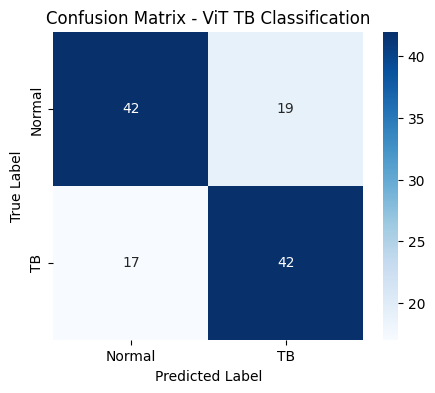

In [49]:
# =========================================
# Cell 15: Confusion Matrix
# =========================================

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "TB"],
    yticklabels=["Normal", "TB"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ViT TB Classification")
plt.show()


“MAE pretraining significantly improved validation performance, demonstrating better feature learning. However, test performance remained similar due to the small size of the test set, which limits statistical confidence. This highlights the need for larger datasets or fine-tuning strategies.”

## some advancements

In [50]:
for name, param in vit_mae.named_parameters():
    if ("blocks.10" in name or "blocks.11" in name or "head" in name):
        param.requires_grad = True
    else:
        param.requires_grad = False

In [51]:
class_weights = torch.tensor([1.0, 1.2]).to(DEVICE)  # TB more important
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, vit_mae.parameters()),
    lr=1e-4
)

In [52]:
# =========================================
# MAE + ViT Training
# =========================================

EPOCHS = 5

for epoch in range(EPOCHS):
    vit_mae.train()
    correct, total = 0, 0
    train_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for images, labels in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = vit_mae(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        train_loss += loss.item()

    train_acc = correct / total

    # Validation
    vit_mae.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = vit_mae(images)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"\nEpoch {epoch+1}")
    print(f"Train Acc: {train_acc:.4f}")
    print(f"Val   Acc: {val_acc:.4f}")


Epoch 1/5: 100%|██████████| 70/70 [00:49<00:00,  1.42it/s]



Epoch 1
Train Acc: 0.8304
Val   Acc: 0.7500


Epoch 2/5: 100%|██████████| 70/70 [00:49<00:00,  1.43it/s]



Epoch 2
Train Acc: 0.8625
Val   Acc: 0.6833


Epoch 3/5: 100%|██████████| 70/70 [00:46<00:00,  1.51it/s]



Epoch 3
Train Acc: 0.8554
Val   Acc: 0.7083


Epoch 4/5: 100%|██████████| 70/70 [00:43<00:00,  1.60it/s]



Epoch 4
Train Acc: 0.8696
Val   Acc: 0.7917


Epoch 5/5: 100%|██████████| 70/70 [00:43<00:00,  1.60it/s]



Epoch 5
Train Acc: 0.8786
Val   Acc: 0.7667


In [53]:
# =========================================
# Save MAE + ViT Model
# =========================================

os.makedirs("./checkpoints/mae_vit", exist_ok=True)
torch.save(vit_mae.state_dict(), "./checkpoints/mae_vit/mae_vit_tb_adv.pth")

print("✅ MAE + ViT model saved")


✅ MAE + ViT model saved


In [54]:
# =========================================
# FINAL MAE + ViT Evaluation (CORRECT)
# =========================================

vit_mae.load_state_dict(
    torch.load("./checkpoints/mae_vit/mae_vit_tb_adv.pth", map_location=DEVICE)
)
vit_mae.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = vit_mae(images)   # ✅ CORRECT MODEL
        preds = outputs.argmax(dim=1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=["Normal", "TB"]))


              precision    recall  f1-score   support

      Normal       0.70      0.77      0.73        61
          TB       0.74      0.66      0.70        59

    accuracy                           0.72       120
   macro avg       0.72      0.72      0.72       120
weighted avg       0.72      0.72      0.72       120



In [56]:
# =========================================
# Cell 13: Evaluation Metrics
# =========================================

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Test Accuracy : {acc:.4f}")
print(f"Precision     : {prec:.4f}")
print(f"Recall        : {rec:.4f}")
print(f"F1-score      : {f1:.4f}")


Test Accuracy : 0.7167
Precision     : 0.7358
Recall        : 0.6610
F1-score      : 0.6964
